# 젠더 폭력 관련 법안 LDA 


## 환경설정

In [30]:
import pandas as pd
import numpy
import matplotlib.pyplot as plt
import seaborn as sns
import re
import logging
import time
import datetime

from gensim.models import word2vec
from konlpy.tag import Okt
%matplotlib inline

from string import punctuation

import gensim
from gensim import corpora, models
from gensim.models import CoherenceModel

import pyLDAvis
import pyLDAvis.gensim
import collections
import warnings
warnings.filterwarnings(action='ignore')

In [31]:
%config InlineBackend.figure_format = 'retina'
!apt -qq -y install fonts-nanum > /dev/null

import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)

Unable to locate an executable at "/Library/Java/JavaVirtualMachines/jdk-14.0.1.jdk/Contents/Home/bin/apt" (-1)


In [32]:
plt.rc('font', family='NanumBarunGothic')

## 1. 데이터 로드 및 확인

In [33]:
bill_df = pd.read_csv('2021-bill-preprocessed.csv', 
                      index_col=0, parse_dates=['제안일자','의결일자','의결처리기간'] )
print(bill_df.shape)
bill_df.columns

(26140, 39)


Index(['의안번호', '의안명', '제안자구분', '제안일자', '의결일자', '의결결과', '제안회기', '제안이유', '소관위원회',
       '제안정당', '법률반영여부', '법률안', 'Unnamed: 13', '개혁보수신당', '국민의당', '기본소득당',
       '대안신당', '대한애국당', '더불어민주당', '더불어시민당', '무소속', '미래를향한전진4.0', '미래통합당',
       '미래한국당', '민생당', '민주평화당', '민중당', '바른미래당', '바른정당', '새누리당', '새로운보수당',
       '새민중정당', '시대전환', '열린민주당', '우리공화당', '자유한국당', '정의당', '의결처리기간', '법률공포여부'],
      dtype='object')

In [34]:
bill_df.drop('Unnamed: 13',1, inplace=True)

## 2. 젠더 폭력 관련 의안 추출

In [67]:
# 한글 전처리
def preprocessing(text): 
    text = re.sub('\\\\n', ' ', text)
    text = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z]', ' ', text)
    return str(text)

# 의미없는 단어 삭제 
def remove_stopword(text): 
    stopwords = ['사이','을','이','의','를','에','가','들','은','는','으로','한','도','항','관','정',
              '수','에서','로','것','그','과','제','입니다','할','하고','적','하는','로부터','면','관','항','이',
              '합니다','와','에게','고','인','하여','등','저','있습니다','말','까지',
              '그리고','다','만','했습니다','안','된','못','일','더','위','최근','인한','있어'
              '있는','해','또한','명','하지','정말','물','많은','것임','류','줄','통해',
              '중','게','너무','자','이런','때','되지','위해','에는','없는','중','물이',
              '및','요','때문','관련','대한','전','라고','되었습니다','하기','나','후','같은','해서',
              '글','되어','주','차','하','내','없이','대해','잘','항','조','경우','함안','기간','하려는','일부',
             '마련','있도록','또는','함','하도록','개월','분','부터','제호','관','되고','년','월','및','등','안','바','이','것','부터','수','시','자']

    text = [word for word in text if word not in stopwords]
    return text

In [68]:
# 의안번호 2014046 2018년 먼저 다크웹 규제 강화 법안 발의 but 임기만료폐기 
keyword = r'.*(N번방|n번방|불법촬영|스토킹|데이트폭력|데이트 폭력|디지털성범죄|사이버범죄|포르노|\
                카르텔|과다노출|사이버 범죄|몰래카메라|몰카|불법 촬영|몸캠|성폭력|성착취|성매매|성범죄|\
                버닝썬|성희롱|딥페이크|복제물|음란|성범죄|n번방|웹하드|촬영물|클럽|성접대|미투|그루밍|성희롱).*'
gender = bill_df[bill_df['의안명'].str.match(keyword) |
           bill_df['제안이유'].str.match(keyword, flags=re.MULTILINE)]
gender = gender.reset_index()
gender = gender.drop('index',1)
gender.shape

(1016, 38)

In [69]:
gender = gender[['의안번호','의안명','의결결과','제안이유']]
gender.head()

,의안번호,의안명,의결결과,제안이유
0,2024979,아동·청소년의 성보호에 관한 법률 일부개정법률안,원안가결,2 대안의 아동？청소년 음란물 범죄의 규모와 형태가 갈수록 교묘해지고 있지만 우...
1,2024963,정보통신망 이용촉진 및 정보보호 등에 관한 법률 일부개정법률안,원안가결,대안의 가 현행법상 금지되는 정보통신망 침해행위에 최근 정보통신망의 정상적인 보호...
2,2024959,전기통신사업법 일부개정법률안,원안가결,2 대안의 일부 기간통신사업자의 서비스별 요금 등에 관한 이용약관에 대하여 인가제...
3,2024926,아동·청소년의 성보호에 관한 법률 일부개정법률안,임기만료폐기,최근 N번방 사건으로 불리는 텔레그램을 통한 아동 청소년 성착취 사건으로 인해 사회...
4,2024925,특정강력범죄의 처벌에 관한 특례법 일부개정법률안,임기만료폐기,최근 N번방 사건으로 불리는 텔레그램을 통한 아동？청소년 성착취 사건으로 사회적 공...


In [70]:
gender['의안텍스트'] = (gender['의안명'] + ' ' + gender['제안이유']).str.strip()
gender['의안텍스트'] = gender['의안텍스트'].apply(lambda x:str(x).lower())

In [71]:
%time gender['의안텍스트'] = gender['의안텍스트'].apply(preprocessing)

CPU times: user 55.5 ms, sys: 2.31 ms, total: 57.8 ms
Wall time: 73.1 ms


In [72]:
from konlpy.tag import Mecab, Okt, Hannanum

# okt = Okt()
hannanum = Hannanum()

def get_tokens(x):
    try:
        return [i for i in hannanum.nouns(x) if len(i) > 1] if x else []
    except Exception as e:
        if str(x) == 'nan':
            return []
        print(e)
        print(str(x))
        raise e

In [73]:
# 단어에서 명사만 뽑아내기
# okt = Okt()
%time gender['tokens'] = gender['의안텍스트'].apply(get_tokens)
gender['tokens'][:3]

CPU times: user 38.3 s, sys: 377 ms, total: 38.7 s
Wall time: 35.7 s


0    [아동, 청소년, 성보호, 법률, 일부개정법률안, 대안, 아동, 청소년, 음란물, ...
1    [정보통신망, 이용촉진, 정보보호, 법률, 일부개정법률안, 대안, 현행법상, 금지,...
2    [전기통신사업법, 일부개정법률안, 대안, 일부, 기간통신사업자, 서비스별, 요금, ...
Name: tokens, dtype: object

In [74]:
%time gender['tokens'] = gender['tokens'].apply(remove_stopword)

CPU times: user 199 ms, sys: 2.93 ms, total: 202 ms
Wall time: 201 ms


In [75]:
%time gender['명사수'] = gender['tokens'].apply(len)

CPU times: user 1.12 ms, sys: 57 µs, total: 1.18 ms
Wall time: 1.13 ms


In [76]:
# 명사 수가 50개를 넘어가는 경우만 추출
gender = gender[gender['명사수'] >= 10]
gender = gender.reset_index(drop=True)
print(gender.shape)

(1014, 7)


In [77]:
gender.head(1)

,의안번호,의안명,의결결과,제안이유,의안텍스트,tokens,명사수
0,2024979,아동·청소년의 성보호에 관한 법률 일부개정법률안,원안가결,2 대안의 아동？청소년 음란물 범죄의 규모와 형태가 갈수록 교묘해지고 있지만 우...,아동 청소년의 성보호에 관한 법률 일부개정법률안 대안의 아동 청소년 음란물 범...,"[아동, 청소년, 성보호, 법률, 일부개정법률안, 대안, 아동, 청소년, 음란물, ...",132


In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Libraries for text preprocessing
import re
import nltk

#nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer#nltk.download('wordnet') 
from nltk.stem.wordnet import WordNetLemmatizer
import os
os.getcwd()

'/Users/harampark/Documents/competition/CUAI-conference/gender-bill-analysis'

In [79]:
corpus = []

for i in range(0, len(gender['tokens'])): 
    pos = PorterStemmer()   # Lemmatisation 
    lem = WordNetLemmatizer()
    text = [lem.lemmatize(word) for word in gender['tokens'][i]]
    text = " ".join(text)


In [46]:
# word2vec 모델 학습에 로그를 찍기
logging.basicConfig(
    format='%(asctime)s : %(levelname)s : %(message)s', 
    level=logging.INFO)

In [48]:
from gensim.models import Word2Vec

# 모델 학습
model = Word2Vec(gender['tokens'], size=100, window = 10, min_count=10, workers=4, iter=100, sg=0)

2020-09-05 14:40:32,301 : INFO : collecting all words and their counts
2020-09-05 14:40:32,303 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-09-05 14:40:32,326 : INFO : collected 8777 word types from a corpus of 91048 raw words and 1014 sentences
2020-09-05 14:40:32,327 : INFO : Loading a fresh vocabulary
2020-09-05 14:40:32,336 : INFO : effective_min_count=10 retains 1412 unique words (16% of original 8777, drops 7365)
2020-09-05 14:40:32,337 : INFO : effective_min_count=10 leaves 73177 word corpus (80% of original 91048, drops 17871)
2020-09-05 14:40:32,343 : INFO : deleting the raw counts dictionary of 8777 items
2020-09-05 14:40:32,344 : INFO : sample=0.001 downsamples 54 most-common words
2020-09-05 14:40:32,345 : INFO : downsampling leaves estimated 61253 word corpus (83.7% of prior 73177)
2020-09-05 14:40:32,350 : INFO : estimated required memory for 1412 words and 100 dimensions: 1835600 bytes
2020-09-05 14:40:32,352 : INFO : resetting layer we

2020-09-05 14:40:33,834 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-05 14:40:33,840 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-05 14:40:33,843 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-05 14:40:33,844 : INFO : EPOCH - 15 : training on 91048 raw words (61273 effective words) took 0.1s, 859096 effective words/s
2020-09-05 14:40:33,906 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-05 14:40:33,911 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-05 14:40:33,912 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-05 14:40:33,915 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-05 14:40:33,917 : INFO : EPOCH - 16 : training on 91048 raw words (61340 effective words) took 0.1s, 964894 effective words/s
2020-09-05 14:40:33,967 : INFO : worker thread finished; awaiting finish of 3 more threads
2020

2020-09-05 14:40:34,936 : INFO : EPOCH - 31 : training on 91048 raw words (61219 effective words) took 0.1s, 1031542 effective words/s
2020-09-05 14:40:34,989 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-05 14:40:34,992 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-05 14:40:34,994 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-05 14:40:34,999 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-05 14:40:35,001 : INFO : EPOCH - 32 : training on 91048 raw words (61294 effective words) took 0.1s, 1022044 effective words/s
2020-09-05 14:40:35,055 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-05 14:40:35,057 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-05 14:40:35,059 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-05 14:40:35,064 : INFO : worker thread finished; awaiting finish of 0 more threads
20

2020-09-05 14:40:36,027 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-05 14:40:36,030 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-05 14:40:36,034 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-05 14:40:36,034 : INFO : EPOCH - 48 : training on 91048 raw words (61318 effective words) took 0.1s, 1083674 effective words/s
2020-09-05 14:40:36,084 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-05 14:40:36,087 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-05 14:40:36,089 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-05 14:40:36,094 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-05 14:40:36,094 : INFO : EPOCH - 49 : training on 91048 raw words (61381 effective words) took 0.1s, 1089759 effective words/s
2020-09-05 14:40:36,145 : INFO : worker thread finished; awaiting finish of 3 more threads
20

2020-09-05 14:40:37,037 : INFO : EPOCH - 64 : training on 91048 raw words (61264 effective words) took 0.1s, 1049118 effective words/s
2020-09-05 14:40:37,088 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-05 14:40:37,091 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-05 14:40:37,093 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-05 14:40:37,099 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-05 14:40:37,099 : INFO : EPOCH - 65 : training on 91048 raw words (61221 effective words) took 0.1s, 1034008 effective words/s
2020-09-05 14:40:37,155 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-05 14:40:37,157 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-05 14:40:37,163 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-05 14:40:37,165 : INFO : worker thread finished; awaiting finish of 0 more threads
20

2020-09-05 14:40:38,109 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-05 14:40:38,112 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-05 14:40:38,116 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-05 14:40:38,118 : INFO : EPOCH - 81 : training on 91048 raw words (61334 effective words) took 0.1s, 996765 effective words/s
2020-09-05 14:40:38,173 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-05 14:40:38,176 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-05 14:40:38,178 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-05 14:40:38,183 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-05 14:40:38,184 : INFO : EPOCH - 82 : training on 91048 raw words (61307 effective words) took 0.1s, 987614 effective words/s
2020-09-05 14:40:38,241 : INFO : worker thread finished; awaiting finish of 3 more threads
2020

2020-09-05 14:40:39,196 : INFO : EPOCH - 97 : training on 91048 raw words (61154 effective words) took 0.1s, 1021179 effective words/s
2020-09-05 14:40:39,259 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-05 14:40:39,264 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-05 14:40:39,265 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-05 14:40:39,268 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-05 14:40:39,269 : INFO : EPOCH - 98 : training on 91048 raw words (61312 effective words) took 0.1s, 931928 effective words/s
2020-09-05 14:40:39,322 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-05 14:40:39,325 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-05 14:40:39,329 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-05 14:40:39,334 : INFO : worker thread finished; awaiting finish of 0 more threads
202

In [49]:
# 모델 이름을 지정하고 저장한다.
model_name = 'genderWords'
model.save(model_name)

2020-09-05 14:40:40,980 : INFO : saving Word2Vec object under genderWords, separately None
2020-09-05 14:40:40,981 : INFO : not storing attribute vectors_norm
2020-09-05 14:40:40,983 : INFO : not storing attribute cum_table
2020-09-05 14:40:40,998 : INFO : saved genderWords


In [50]:
len(model.wv.vocab)

1412

In [52]:
# vocab = model.wv.vocab
print(model.wv.most_similar('n번방'))
print(model.wv.most_similar('청소년'))

[('텔레그램', 0.8048868179321289), ('성착취', 0.5969118475914001), ('공분', 0.5938934087753296), ('국민적', 0.43202781677246094), ('온라인', 0.42599719762802124), ('올해', 0.4188757538795471), ('검거', 0.40825265645980835), ('피해자들', 0.3995211720466614), ('다크웹', 0.39355409145355225), ('사이버', 0.385314017534256)]
[('아동', 0.6484574675559998), ('청소년대상', 0.46406328678131104), ('취업제한', 0.3831506371498108), ('청소년이용음란물', 0.3735472857952118), ('청소년성착취물', 0.3676297664642334), ('그루밍', 0.34739023447036743), ('권유', 0.33388304710388184), ('성착취', 0.32541656494140625), ('유인', 0.32407844066619873), ('허용', 0.32305264472961426)]


In [53]:
word_vectors = model.wv
vocabs = model.wv.vocab.keys()
word_vectors_list = [word_vectors[v] for v in vocabs]

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
xys = pca.fit_transform(word_vectors_list)
xs = xys[:,0]
ys=xys[:,1]

In [54]:
# 한글폰트 설정
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
!apt -qq -y install fonts-nanum
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

Unable to locate an executable at "/Library/Java/JavaVirtualMachines/jdk-14.0.1.jdk/Contents/Home/bin/apt" (-1)


2020-09-05 14:41:02,182 : INFO : Generating new fontManager, this may take some time...
2020-09-05 14:41:02,844 : INFO : Failed to extract font properties from /System/Library/Fonts/Supplemental/NISC18030.ttf: In FT2Font: Could not set the fontsize (error code 0x17)
2020-09-05 14:41:03,804 : INFO : Failed to extract font properties from /System/Library/Fonts/LastResort.otf: tuple indices must be integers or slices, not str
2020-09-05 14:41:03,930 : INFO : Failed to extract font properties from /System/Library/Fonts/Apple Color Emoji.ttc: In FT2Font: Could not set the fontsize (error code 0x17)


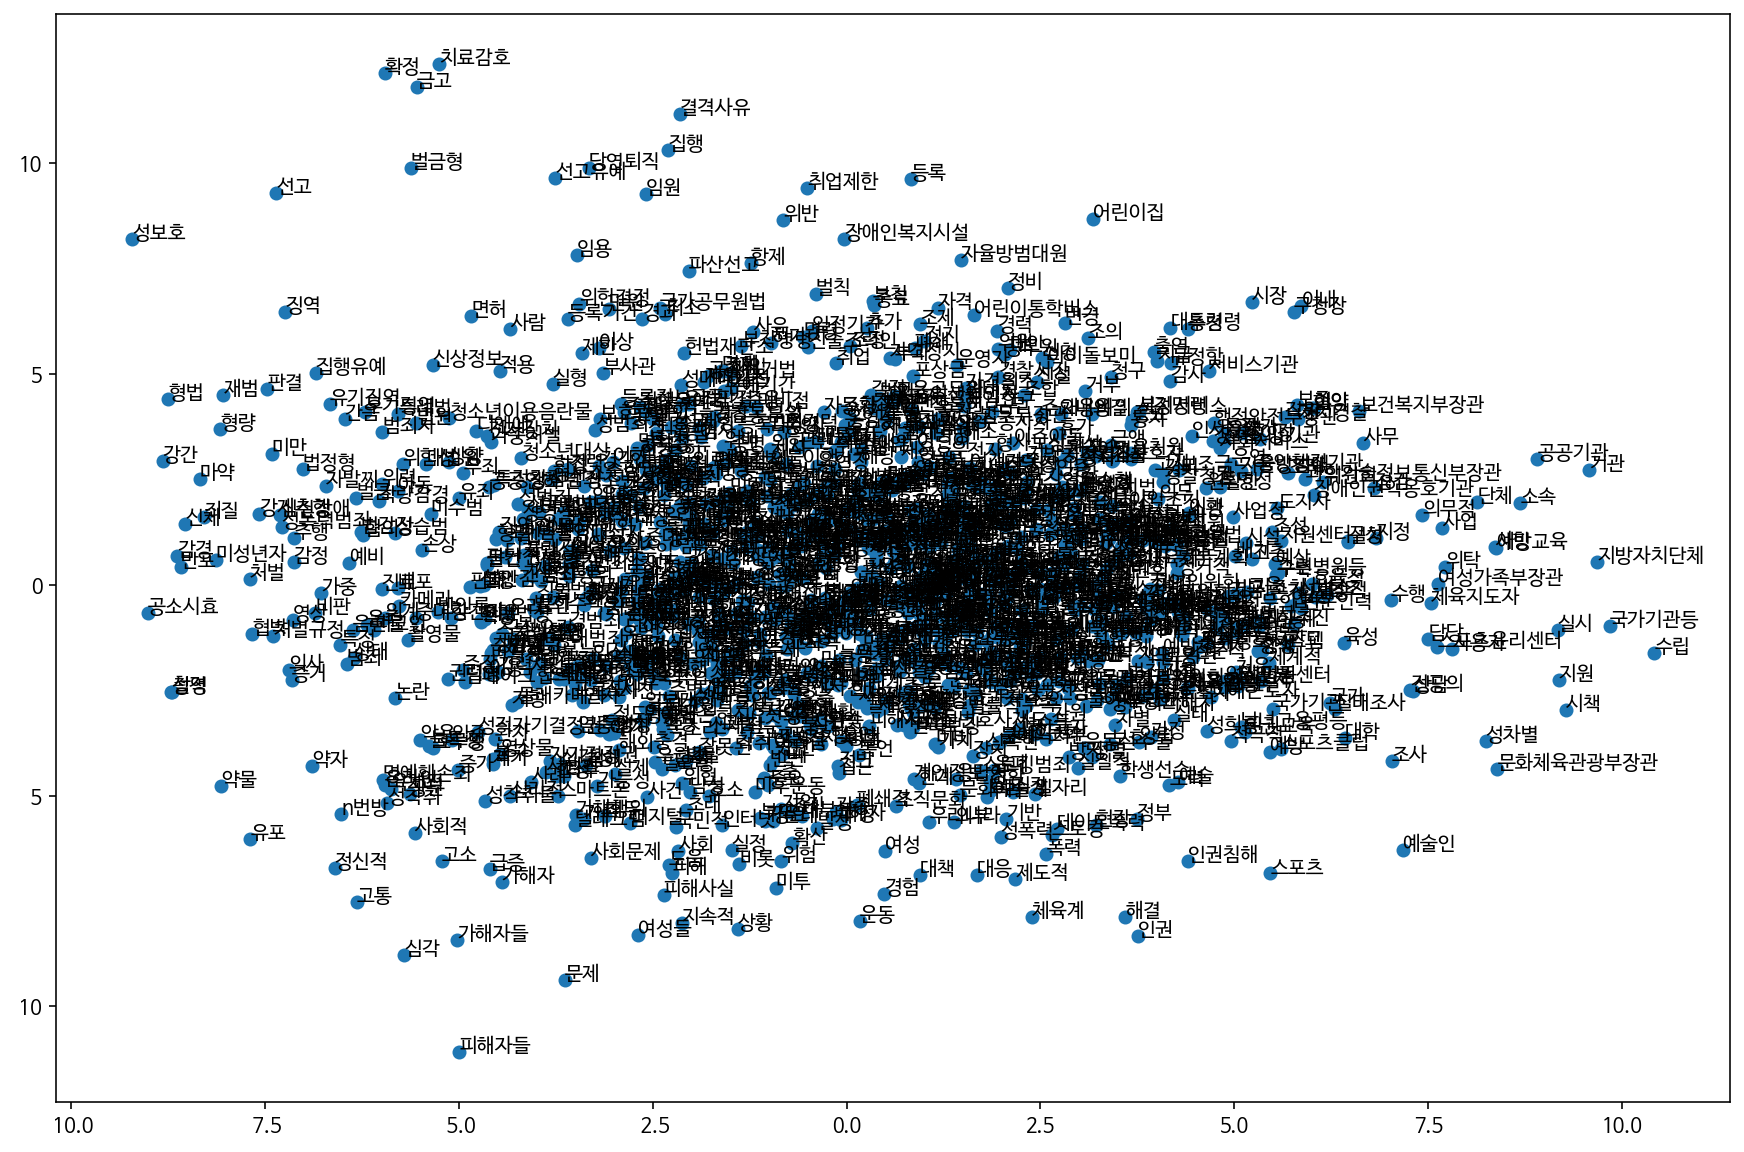

In [55]:
import matplotlib.pyplot as plt

def plot_2d_graph(vocabs, xs, ys):
    plt.figure(figsize=(15,10))
    plt.scatter(xs,ys,marker='o')
    for i,v in enumerate(vocabs):
        plt.annotate(v,xy=(xs[i], ys[i]))
        
plot_2d_graph(vocabs, xs,ys)

### Plotly로 html 시각화

In [56]:
# annotation text 만들기 (시각화할 때 벡터 말고 단어도 필요하니까)
# vocabs = word_vectors.vocab.keys()

text=[]
for i,v in enumerate(vocabs):
    text.append(v)

In [57]:
import plotly
import plotly.graph_objects as go
plt.figure(figsize=(15,10))
fig = go.Figure(data=go.Scatter(x=xs,
                                y=ys,
                                mode='markers+text',
                                text=text)) 

fig.update_layout(title='gender Word2Vec')
fig.show()

plotly.offline.plot(
fig, filename='gender_word2vec.html'
)

'gender_word2vec.html'

<Figure size 1080x720 with 0 Axes>

## 법안 토픽 모델링

In [23]:
stopword_list = ['법률', '경우', '대한', '일부', '개정','것임', '관련','현행법','위원회','조의','국회법',\
                  '조제', '관련', '내용', '사항', '발생', '행위', '운영', '업무','이상', '신설', '규정',\
                  '해당', '기준', '마련', '설치', '사항', '대상', '또는', '있음', '대해', '대하', '거나']

In [24]:
###################### 텍스트전처리 ######################

def Preproc(textlist):
    removedict = ['법률','법률안','사업','지원','위원회', '관리','국가','해당','발생','관련','사항','있음', '제조', '제항', '경우', '대한', \
                '일부', '개정', '것임','현행법','조의','국회법','조제', '내용', '행위', '운영', '업무','이상', '신설', '규정','현행',\
                '기준', '마련', '설치', '대상', '또는', '대해', '대하', '거나', '개정', '함안', '개정', '임안']
    ## 특수문자 제거 & 명사추출
    hannanum = Hannanum()
    cleanlist = []
    nounlist = []
    
    for i in range(len(textlist)):
        n = re.sub('[-=.#/:$}·,■?]','',str(textlist[i]))
        k = re.sub('[0-9]','',n)
        nounlist.append(hannanum.nouns(k))
    
    for i in nounlist:
        for j in i:
            if len(j)==1:
                i.remove(j)
    for i in nounlist:
        for j in i:
            if j in removedict:
                i.remove(j)
    for i in nounlist:
        for j in i:
            if j in stopword_list:
                i.remove(j)

    cleanlist = nounlist
    
    return cleanlist

###################### 상위 50개 단어 제거 ######################


def remove_common(cleanlist):
    collections.Counter()

    flat=[]
    for i in cleanlist:
        for j in i:
            if (j not in stopword_list) or (len(j)!=1):
                flat.append(j)
                    
                    
    commoncount = collections.Counter(flat)
    commoncount = commoncount.most_common(50)

    newdict = []

    for i in range(len(commoncount)): #50
        newdict.append(commoncount[i][0])
 
    for i in cleanlist:
        if i in newdict:
            cleanlist.remove(i)
    
    return cleanlist, newdict

###################### 말뭉치 ######################

def make_corpus(cleanlist):

    dictionary = corpora.Dictionary(cleanlist)
    corpus = [dictionary.doc2bow(text) for text in cleanlist]
    
    return corpus, dictionary, cleanlist

###################### 토픽수최적화 ######################

def coh_visual(corpus, dictionary, cleanlist):
    
    coherence_values = []
    
    for i in range(2,20):
        ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = i, id2word = dictionary)
        coherence_model_lda = CoherenceModel(model = ldamodel, texts = cleanlist, dictionary = dictionary, topn=10)
        coherence_lda = coherence_model_lda.get_coherence()
        coherence_values.append(coherence_lda)
    
    x = range(2,20)
    plt.plot(x, coherence_values)
    plt.xlabel('number of topics')
    plt.ylabel('coherence score')
    plt.show()
      
###################### 언어모델평가 ######################

def perp_visual(corpus, dictionary):
    
    perplexity_values = []
    
    for i in range(2,20):
        ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = i, id2word = dictionary)
        perplexity_values.append(ldamodel.log_perplexity(corpus))
    
    x = range(2,20)
    plt.plot(x, perplexity_values)
    plt.xlabel('number of topics')
    plt.ylabel('perplexity score')
    plt.show()

In [25]:
# 젠더 법안 하나의 리스트로! 
gender_text_list = []
for i in gender['제안이유']:
    gender_text_list.append(i)

2020-09-05 14:34:32,168 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-09-05 14:34:32,267 : INFO : built Dictionary(5014 unique tokens: ['각심', '갈수록', '강간', '강제추행', '경향']...) from 1016 documents (total 102961 corpus positions)
2020-09-05 14:34:32,331 : INFO : using symmetric alpha at 0.5
2020-09-05 14:34:32,332 : INFO : using symmetric eta at 0.5
2020-09-05 14:34:32,333 : INFO : using serial LDA version on this node
2020-09-05 14:34:32,344 : INFO : running online (single-pass) LDA training, 2 topics, 1 passes over the supplied corpus of 1016 documents, updating model once every 1016 documents, evaluating perplexity every 1016 documents, iterating 50x with a convergence threshold of 0.001000
2020-09-05 14:34:32,345 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2020-09-05 14:34:33,517 : INFO : -8.938 per-word bound, 490.5 perplexity estimate based on a held-out corpus of 1016 docume

2020-09-05 14:34:46,146 : INFO : topic #3 (0.200): 0.020*"제조" + 0.013*"청소년" + 0.012*"성폭력" + 0.012*"범죄" + 0.012*"안" + 0.010*"성범죄" + 0.010*"아동" + 0.009*"피해" + 0.008*"처벌" + 0.007*"사유"
2020-09-05 14:34:46,147 : INFO : topic #4 (0.200): 0.021*"범죄" + 0.021*"성폭력" + 0.019*"피해자" + 0.019*"제조" + 0.015*"촬영" + 0.012*"보호" + 0.011*"처벌" + 0.007*"사람" + 0.006*"청소년" + 0.006*"이하"
2020-09-05 14:34:46,148 : INFO : topic diff=2.484190, rho=1.000000
2020-09-05 14:34:46,151 : INFO : using ParallelWordOccurrenceAccumulator(processes=3, batch_size=64) to estimate probabilities from sliding windows
2020-09-05 14:34:46,365 : INFO : 1 batches submitted to accumulate stats from 64 documents (71 virtual)
2020-09-05 14:34:47,305 : INFO : 11 batches submitted to accumulate stats from 704 documents (-7329 virtual)
2020-09-05 14:34:47,327 : INFO : 13 batches submitted to accumulate stats from 832 documents (-7221 virtual)
2020-09-05 14:34:47,332 : INFO : 14 batches submitted to accumulate stats from 896 documents (-7137 

2020-09-05 14:34:56,639 : INFO : using ParallelWordOccurrenceAccumulator(processes=3, batch_size=64) to estimate probabilities from sliding windows
2020-09-05 14:34:56,844 : INFO : 1 batches submitted to accumulate stats from 64 documents (71 virtual)
2020-09-05 14:34:57,777 : INFO : 11 batches submitted to accumulate stats from 704 documents (-7334 virtual)
2020-09-05 14:34:57,801 : INFO : 13 batches submitted to accumulate stats from 832 documents (-7226 virtual)
2020-09-05 14:34:57,806 : INFO : 14 batches submitted to accumulate stats from 896 documents (-7142 virtual)
2020-09-05 14:34:57,960 : INFO : 3 accumulators retrieved from output queue
2020-09-05 14:34:57,966 : INFO : accumulated word occurrence stats for 21480 virtual documents
2020-09-05 14:34:58,063 : INFO : using symmetric alpha at 0.1111111111111111
2020-09-05 14:34:58,064 : INFO : using symmetric eta at 0.1111111111111111
2020-09-05 14:34:58,066 : INFO : using serial LDA version on this node
2020-09-05 14:34:58,071 : I

2020-09-05 14:35:09,155 : INFO : 3 accumulators retrieved from output queue
2020-09-05 14:35:09,162 : INFO : accumulated word occurrence stats for 21482 virtual documents
2020-09-05 14:35:09,303 : INFO : using symmetric alpha at 0.08333333333333333
2020-09-05 14:35:09,304 : INFO : using symmetric eta at 0.08333333333333333
2020-09-05 14:35:09,306 : INFO : using serial LDA version on this node
2020-09-05 14:35:09,313 : INFO : running online (single-pass) LDA training, 12 topics, 1 passes over the supplied corpus of 1016 documents, updating model once every 1016 documents, evaluating perplexity every 1016 documents, iterating 50x with a convergence threshold of 0.001000
2020-09-05 14:35:09,314 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2020-09-05 14:35:10,417 : INFO : -9.891 per-word bound, 949.8 perplexity estimate based on a held-out corpus of 1016 documents with 102961 words
2020-09-05 14:35:10,4

2020-09-05 14:35:22,422 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2020-09-05 14:35:23,506 : INFO : -10.204 per-word bound, 1179.8 perplexity estimate based on a held-out corpus of 1016 documents with 102961 words
2020-09-05 14:35:23,507 : INFO : PROGRESS: pass 0, at document #1016/1016
2020-09-05 14:35:24,454 : INFO : topic #5 (0.067): 0.026*"성폭력" + 0.025*"제조" + 0.016*"범죄" + 0.015*"피해자" + 0.010*"피해" + 0.009*"보호" + 0.009*"안" + 0.009*"징계" + 0.008*"처벌" + 0.008*"성희롱"
2020-09-05 14:35:24,455 : INFO : topic #2 (0.067): 0.028*"제조" + 0.014*"피해" + 0.013*"보호" + 0.011*"청소년" + 0.011*"안" + 0.010*"아동" + 0.010*"기관" + 0.010*"성매매" + 0.008*"성희롱" + 0.008*"성폭력"
2020-09-05 14:35:24,456 : INFO : topic #8 (0.067): 0.022*"아동" + 0.017*"청소년" + 0.015*"제조" + 0.014*"촬영" + 0.012*"처벌" + 0.012*"범죄" + 0.012*"성폭력" + 0.010*"성범죄" + 0.009*"피해자" + 0.008*"보호"
2020-09-05 14:35:24,456 : INFO : topic #1 (0.067): 0.023*"피해자" + 0.017*"제조" 

2020-09-05 14:35:37,084 : INFO : topic #2 (0.056): 0.019*"피해자" + 0.016*"범죄" + 0.015*"아동" + 0.012*"성범죄" + 0.012*"사람" + 0.012*"청소년" + 0.012*"제조" + 0.009*"피해" + 0.009*"보호" + 0.009*"장애인"
2020-09-05 14:35:37,085 : INFO : topic #12 (0.056): 0.017*"성폭력" + 0.016*"처벌" + 0.014*"제조" + 0.014*"범죄" + 0.011*"기관" + 0.010*"성범죄" + 0.010*"피해자" + 0.008*"사람" + 0.008*"안" + 0.007*"장기"
2020-09-05 14:35:37,086 : INFO : topic #4 (0.056): 0.016*"제조" + 0.012*"성폭력" + 0.012*"범죄" + 0.012*"성희롱" + 0.010*"피해자" + 0.007*"조치" + 0.007*"인권" + 0.007*"예방" + 0.007*"안" + 0.007*"보호"
2020-09-05 14:35:37,087 : INFO : topic diff=9.268524, rho=1.000000
2020-09-05 14:35:37,092 : INFO : using ParallelWordOccurrenceAccumulator(processes=3, batch_size=64) to estimate probabilities from sliding windows
2020-09-05 14:35:37,319 : INFO : 1 batches submitted to accumulate stats from 64 documents (71 virtual)
2020-09-05 14:35:38,538 : INFO : 11 batches submitted to accumulate stats from 704 documents (-7327 virtual)
2020-09-05 14:35:38,585 : 

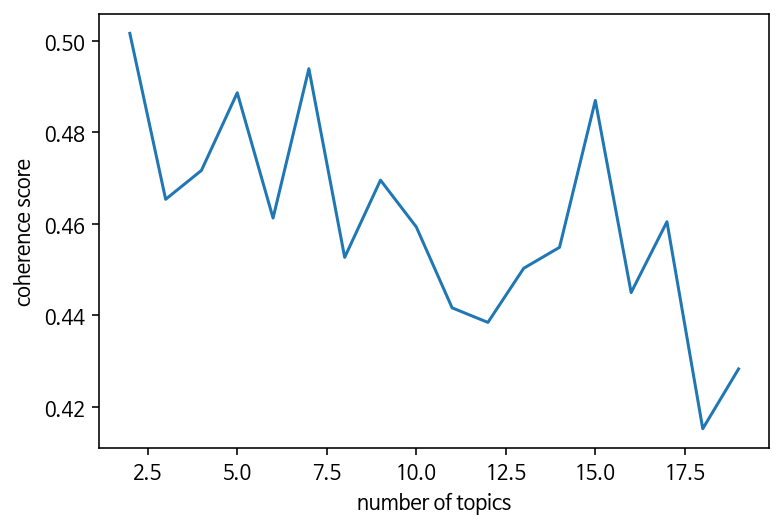

In [26]:
gender_clean = Preproc(gender_text_list)
gender_corpus, gender_dictionary, gender_cleanlist = make_corpus(gender_clean)
coh_visual(gender_corpus, gender_dictionary, gender_cleanlist)

2020-09-05 14:35:43,410 : INFO : using symmetric alpha at 0.5
2020-09-05 14:35:43,411 : INFO : using symmetric eta at 0.5
2020-09-05 14:35:43,413 : INFO : using serial LDA version on this node
2020-09-05 14:35:43,417 : INFO : running online (single-pass) LDA training, 2 topics, 1 passes over the supplied corpus of 1016 documents, updating model once every 1016 documents, evaluating perplexity every 1016 documents, iterating 50x with a convergence threshold of 0.001000
2020-09-05 14:35:43,418 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2020-09-05 14:35:44,531 : INFO : -8.936 per-word bound, 489.9 perplexity estimate based on a held-out corpus of 1016 documents with 102961 words
2020-09-05 14:35:44,532 : INFO : PROGRESS: pass 0, at document #1016/1016
2020-09-05 14:35:45,425 : INFO : topic #0 (0.500): 0.020*"범죄" + 0.019*"제조" + 0.017*"성폭력" + 0.015*"피해자" + 0.011*"처벌" + 0.009*"보호" + 0.008*"안" + 0.008*"성

2020-09-05 14:35:58,022 : INFO : topic #3 (0.167): 0.029*"제조" + 0.015*"청소년" + 0.014*"아동" + 0.012*"처벌" + 0.012*"범죄" + 0.011*"안" + 0.011*"성폭력" + 0.009*"피해자" + 0.009*"보호" + 0.007*"사람"
2020-09-05 14:35:58,026 : INFO : topic #1 (0.167): 0.019*"범죄" + 0.017*"피해자" + 0.016*"청소년" + 0.016*"성폭력" + 0.015*"아동" + 0.013*"제조" + 0.012*"피해" + 0.010*"보호" + 0.010*"처벌" + 0.008*"촬영"
2020-09-05 14:35:58,028 : INFO : topic diff=2.863466, rho=1.000000
2020-09-05 14:35:59,078 : INFO : -7.175 per-word bound, 144.5 perplexity estimate based on a held-out corpus of 1016 documents with 102961 words
2020-09-05 14:35:59,078 : INFO : using symmetric alpha at 0.14285714285714285
2020-09-05 14:35:59,079 : INFO : using symmetric eta at 0.14285714285714285
2020-09-05 14:35:59,080 : INFO : using serial LDA version on this node
2020-09-05 14:35:59,087 : INFO : running online (single-pass) LDA training, 7 topics, 1 passes over the supplied corpus of 1016 documents, updating model once every 1016 documents, evaluating perplexi

2020-09-05 14:36:10,914 : INFO : topic diff=4.694837, rho=1.000000
2020-09-05 14:36:11,830 : INFO : -7.240 per-word bound, 151.2 perplexity estimate based on a held-out corpus of 1016 documents with 102961 words
2020-09-05 14:36:11,831 : INFO : using symmetric alpha at 0.09090909090909091
2020-09-05 14:36:11,832 : INFO : using symmetric eta at 0.09090909090909091
2020-09-05 14:36:11,834 : INFO : using serial LDA version on this node
2020-09-05 14:36:11,840 : INFO : running online (single-pass) LDA training, 11 topics, 1 passes over the supplied corpus of 1016 documents, updating model once every 1016 documents, evaluating perplexity every 1016 documents, iterating 50x with a convergence threshold of 0.001000
2020-09-05 14:36:11,841 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2020-09-05 14:36:13,078 : INFO : -9.783 per-word bound, 880.9 perplexity estimate based on a held-out corpus of 1016 document

2020-09-05 14:36:23,996 : INFO : using symmetric alpha at 0.06666666666666667
2020-09-05 14:36:23,996 : INFO : using symmetric eta at 0.06666666666666667
2020-09-05 14:36:23,998 : INFO : using serial LDA version on this node
2020-09-05 14:36:24,007 : INFO : running online (single-pass) LDA training, 15 topics, 1 passes over the supplied corpus of 1016 documents, updating model once every 1016 documents, evaluating perplexity every 1016 documents, iterating 50x with a convergence threshold of 0.001000
2020-09-05 14:36:24,007 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2020-09-05 14:36:25,080 : INFO : -10.210 per-word bound, 1184.4 perplexity estimate based on a held-out corpus of 1016 documents with 102961 words
2020-09-05 14:36:25,080 : INFO : PROGRESS: pass 0, at document #1016/1016
2020-09-05 14:36:25,917 : INFO : topic #2 (0.067): 0.024*"피해자" + 0.017*"촬영" + 0.016*"제조" + 0.011*"피해" + 0.011*"성폭력" 

2020-09-05 14:36:36,856 : INFO : running online (single-pass) LDA training, 19 topics, 1 passes over the supplied corpus of 1016 documents, updating model once every 1016 documents, evaluating perplexity every 1016 documents, iterating 50x with a convergence threshold of 0.001000
2020-09-05 14:36:36,856 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2020-09-05 14:36:38,203 : INFO : -10.680 per-word bound, 1641.1 perplexity estimate based on a held-out corpus of 1016 documents with 102961 words
2020-09-05 14:36:38,204 : INFO : PROGRESS: pass 0, at document #1016/1016
2020-09-05 14:36:39,126 : INFO : topic #5 (0.053): 0.027*"피해자" + 0.020*"제조" + 0.017*"범죄" + 0.011*"아동" + 0.010*"보호" + 0.009*"성폭력" + 0.009*"카메라" + 0.008*"사유" + 0.007*"피해" + 0.007*"청소년"
2020-09-05 14:36:39,128 : INFO : topic #11 (0.053): 0.021*"범죄" + 0.020*"촬영" + 0.019*"제조" + 0.019*"처벌" + 0.015*"성폭력" + 0.014*"청소년" + 0.013*"피해자" + 0.008*"성범죄" 

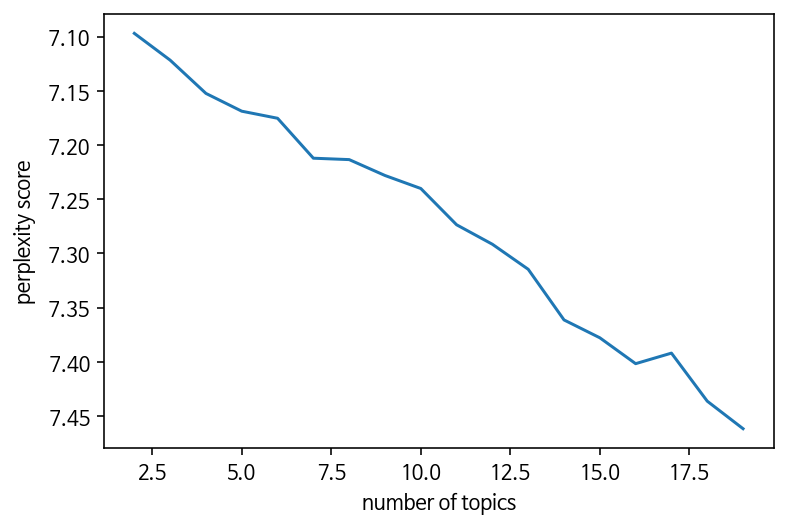

In [27]:
perp_visual(gender_corpus, gender_dictionary)

In [28]:
ldamodel = gensim.models.ldamodel.LdaModel(gender_corpus, num_topics=10, alpha=0.1, id2word = gender_dictionary)

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel, gender_corpus, gender_dictionary)
vis

2020-09-05 14:36:40,536 : INFO : using symmetric eta at 0.1
2020-09-05 14:36:40,540 : INFO : using serial LDA version on this node
2020-09-05 14:36:40,546 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 1016 documents, updating model once every 1016 documents, evaluating perplexity every 1016 documents, iterating 50x with a convergence threshold of 0.001000
2020-09-05 14:36:40,547 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2020-09-05 14:36:41,712 : INFO : -9.682 per-word bound, 821.3 perplexity estimate based on a held-out corpus of 1016 documents with 102961 words
2020-09-05 14:36:41,714 : INFO : PROGRESS: pass 0, at document #1016/1016
2020-09-05 14:36:42,614 : INFO : topic #5 (0.100): 0.029*"범죄" + 0.020*"피해자" + 0.018*"제조" + 0.016*"성폭력" + 0.009*"안" + 0.008*"사유" + 0.007*"사람" + 0.006*"처벌" + 0.006*"제호" + 0.006*"보호"
2020-09-05 14:36:42,615 : INFO :

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.011309 -0.028222       1        1  21.652468
8     -0.007644 -0.000371       2        1  13.535838
5      0.038417 -0.055188       3        1  11.977660
7     -0.025695 -0.018968       4        1  10.949185
9     -0.015636 -0.002194       5        1  10.072097
0     -0.017460  0.016737       6        1   7.074662
2      0.101699  0.026761       7        1   6.949425
6     -0.017769  0.076809       8        1   6.733118
1     -0.036265 -0.003001       9        1   5.550907
3     -0.008338 -0.012363      10        1   5.504648, topic_info=     Term         Freq        Total Category  logprob  loglift
156    촬영   492.000000   492.000000  Default  30.0000  30.0000
19     범죄  1694.000000  1694.000000  Default  29.0000  29.0000
1249   체육   254.000000   254.000000  Default  28.0000  28.0000
3193   방범   167.000000   167.000000  Default  27.0000  27.0000
191   성폭력  1500.000000  1500.000000  Default  26.0000  26.0000
...   ...          ...          ...      ...      ...      ...
142    정보    24.060713   437.457428  Topic10  -5.4619  -0.0008
96     사건    24.244717   459.058807  Topic10  -5.4543  -0.0414
35      안    26.200657   844.595215  Topic10  -5.3767  -0.5735
166    피해    23.784719   755.315186  Topic10  -5.4735  -0.5585
43     이용    22.431780   499.389801  Topic10  -5.5320  -0.2033

[801 rows x 6 columns], token_table=      Topic      Freq Term
term                      
1726      1  0.089709   가맹
1726      4  0.493397   가맹
1726      7  0.044854   가맹
1726      8  0.089709   가맹
1726     10  0.269126   가맹
...     ...       ...  ...
290      10  0.053115   활동
4164      3  0.698552   효용
4164      5  0.232851   효용
4581      2  0.229843   후견
4581      4  0.459686   후견

[2805 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 9, 6, 8, 10, 1, 3, 7, 2, 4])

In [42]:
gender_text_list

['2  대안의 아동？청소년 음란물 범죄의 규모와 형태가 갈수록 교묘해지고 있지만  우리나라의 아동 대상 성범죄에 대한 처벌이 지나치게 관대해 실효성이 떨어진다는 비판이 커지고 있는 바  이에 아동？청소년 대상 성범죄의 경우 형의 하한을 설정하고  예비 음모 및 구입 시청 광고 소개하는 경우에도 처벌받도록 하여 경각심을 제고할 필요가 있음 또한  아동 청소년을 대상으로 하는 음란물은 그 자체로 아동 청소년에 대한 성착취 및 학대를 의미하는 것임에도 불구하고  막연히 아동 청소년을 ‘이용’하는 음란물의 의미로 가볍게 해석되는 경향이 있어 온 바  이에 “아동 청소년이용음란물”을 “아동 청소년성착취물”이라는 용어로 변경해 아동청소년이용음란물이 ‘성착취 성학대’ 임을 명확하게 할 필요가 있음 그 밖에 아동 청소년성착취물의 배포 제공 광고 소개 및 구입 소지 시청 등의 죄에 대한 벌금형을 삭제함에 따라 이를 조정하고  아동 청소년이용음란물 범죄를 수사기관에 신고한 자에 대해 신고포상금을 지급할 수 있도록 하여 아동 청소년의 성보호를 강화할 필요가 있음 3  대안의 주요내용가  ‘아동 청소년이용음란물’을 ‘아동 청소년성착취물’로 그 용어를 변경함(안 제2조제5호  안 제12조  안 제17조)나  아동ㆍ청소년에 대한 강간ㆍ강제추행 등의 죄를 범할 목적으로 예비 또는 음모한 경우 처벌하도록 함(안 제7조의2 신설) 다  아동 청소년성착취물의 제작 배포 등에 관한 죄의 형량을 강화함(안 제11조) 라  아동 청소년성착취물의 배포 제공 광고 소개 및 구입 소지 시청 등의 죄에 대한 벌금형이 삭제됨에 따라 이를 조정함(안 제56조제1항) 마  아동 청소년성착취물의 제작 배포 등에 관한 죄를 신고한 사람에게 포상금을 지급할 수 있도록 함(안 제59조제1항)',
 '대안의 가  현행법상 금지되는 정보통신망 침해행위에 최근 정보통신망의 정상적인 보호 인증 절차를 우회하여 정보통신망에 접근할 수 있도록 하는 프로그램이나 기술적 장치 등(이하 “백도어”라 함)를 정보통신망 또는 정보시스